# A DATA ANALYSIS FOR MICROSOFT MOVIE STUDIO
## Goals:
    1. Prepare the provide data
    2. Do analysis on the data
    3. Generate insights 

In [1]:
#importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sqlite3
import string
import random
import requests
from bs4 import BeautifulSoup

In [212]:
#1. opening bom.movie_gross file and creating a dataframe
bom_movie_gross = pd.read_csv('.data/bom.movie_gross.csv')

#2. opening rt.movie_info file and creating a dataframe
rt_movie_info = pd.read_csv('.data/rt.movie_info.tsv', sep = '\t', index_col=0)

#3. opening rt.reviews file and creating a dataframe
rt_reviews = pd.read_csv('.data/rt.reviews.tsv', encoding = 'unicode_escape', sep = '\t', index_col=0)

#4. opening tmdb.movies file and creating a dataframe
tmdb_movies = pd.read_csv('.data/tmdb.movies.csv', index_col=0)

#5. opening tn.movie_budgets file and creating a dataframe
tn_movie_budgets = pd.read_csv('.data/tn.movie_budgets.csv', index_col=0)

#5. opening imdb_movies file and creating a dataframe
movies_year = pd.read_csv('.data/imdb_movies.tsv', delimiter='\t', usecols=['titleType', 'primaryTitle', 
                            'startYear', 'runtimeMinutes'], encoding='utf-8')

#6. opening imdb file and creating a dataframe
    #query the database and join the tables movie basics and movie ratings
conn = sqlite3.connect('.data/im.db')


#### Function for checking various information about a dataframe

In [3]:
def df_info(df):
    df_shape = df.shape
    missing_sum = df.isna().sum()
    names = df.columns
    info = df.info()
    print('\033[95m' + f'Column names: {names}' +  '\033[0m')
    print(f'Shape: {df_shape}')
    print(f'Df info: {info}')
    print('\033[94m' + 'Missing sum:' + '\033[0m')
    print('\033[94m' + f' {missing_sum}' + '\033[0m')
    return

### Joining movie basics table with movie ratings and movie akas tables

In [4]:
#joining tables and creating a dataframe
imdb = pd.read_sql('''SELECT *
                      FROM movie_basics
                      JOIN ( SELECT averagerating, numvotes, region, movie_id
                             FROM movie_ratings
                             JOIN movie_akas
                             USING(movie_id)
                           ) ratings
                       USING(movie_id)
''', conn)

#### cleaning the dataframe formed after joining the tables

In [5]:
imdb

movie_id              primary_title             original_title  \
0       tt0063540                  Sunghursh                  Sunghursh   
1       tt0063540                  Sunghursh                  Sunghursh   
2       tt0063540                  Sunghursh                  Sunghursh   
3       tt0063540                  Sunghursh                  Sunghursh   
4       tt0063540                  Sunghursh                  Sunghursh   
...           ...                        ...                        ...   
261801  tt9905462                  Pengalila                  Pengalila   
261802  tt9905462                  Pengalila                  Pengalila   
261803  tt9911774  Padmavyuhathile Abhimanyu  Padmavyuhathile Abhimanyu   
261804  tt9911774  Padmavyuhathile Abhimanyu  Padmavyuhathile Abhimanyu   
261805  tt9911774  Padmavyuhathile Abhimanyu  Padmavyuhathile Abhimanyu   

        start_year  runtime_minutes              genres  averagerating  \
0             2013            175.0  Action,Crime,Drama            7.0   
1             2013            175.0  Action,Crime,Drama            7.0   
2             2013            175.0  Action,Crime,Drama            7.0   
3             2013            175.0  Action,Crime,Drama            7.0   
4             2013            175.0  Action,Crime,Drama            7.0   
...            ...              ...                 ...            ...   
261801        2019            111.0               Drama            8.4   
261802        2019            111.0               Drama            8.4   
261803        2019            130.0               Drama            8.4   
261804        2019            130.0               Drama            8.4   
261805        2019            130.0               Drama            8.4   

        numvotes region  
0             77   None  
1             77     IN  
2             77     IN  
3             77     IN  
4             77     IN  
...          ...    ...  
261801       600     IN  
261802       600     IN  
261803       365   None  
261804       365     IN  
261805       365     IN  

[261806 rows x 9 columns]

In [6]:
#removing duplicated rows
imdb = imdb.drop_duplicates()

#removing null rows in region rows with the string none
imdb = imdb[(imdb['region'].notna()) & (imdb['region'] != 'None')]

#drop duplicated rows while merging the region values
imdb = imdb.groupby('movie_id', as_index=False).agg({'primary_title': 'first',
                                                  'original_title': 'first',
                                                  'start_year': 'first',
                                                  'runtime_minutes': 'first',
                                                  'genres': 'first',
                                                  'averagerating': 'first',
                                                  'numvotes': 'first',
                                                  'region': ', '.join})

imdb

movie_id                    primary_title  \
0      tt0063540                        Sunghursh   
1      tt0066787  One Day Before the Rainy Season   
2      tt0069049       The Other Side of the Wind   
3      tt0069204                  Sabse Bada Sukh   
4      tt0100275         The Wandering Soap Opera   
...          ...                              ...   
69547  tt9899860   Watching This Movie Is a Crime   
69548  tt9899880                         Columbus   
69549  tt9903952      BADMEN with a good behavior   
69550  tt9905462                        Pengalila   
69551  tt9911774        Padmavyuhathile Abhimanyu   

                    original_title  start_year  runtime_minutes  \
0                        Sunghursh        2013            175.0   
1                  Ashad Ka Ek Din        2019            114.0   
2       The Other Side of the Wind        2018            122.0   
3                  Sabse Bada Sukh        2018              NaN   
4            La Telenovela Errante        2017             80.0   
...                            ...         ...              ...   
69547       Didan in film jorm ast        2019            100.0   
69548                     Columbus        2018             85.0   
69549  BADMEN with a good behavior        2018             87.0   
69550                    Pengalila        2019            111.0   
69551    Padmavyuhathile Abhimanyu        2019            130.0   

                     genres  averagerating  numvotes  \
0        Action,Crime,Drama            7.0        77   
1           Biography,Drama            7.2        43   
2                     Drama            6.9      4517   
3              Comedy,Drama            6.1        13   
4      Comedy,Drama,Fantasy            6.5       119   
...                     ...            ...       ...   
69547        Drama,Thriller            8.1         7   
69548                Comedy            5.8         5   
69549         Comedy,Horror            9.2         5   
69550                 Drama            8.4       600   
69551                 Drama            8.4       365   

                                               region  
0                                                  IN  
1                                             IN, XWW  
2      AR, BR, DE, ES, FR, GB, IT, PL, PT, RU, US, VE  
3                                                  IN  
4                                         CL, PL, XWW  
...                                               ...  
69547                                         IR, XWW  
69548                                              IR  
69549                                              DE  
69550                                              IN  
69551                                              IN  

[69552 rows x 9 columns]

In [7]:
#checking which columns have missing data
imdb.isna().sum()

movie_id              0
primary_title         0
original_title        0
start_year            0
runtime_minutes    6741
genres              637
averagerating         0
numvotes              0
region                0
dtype: int64

In [8]:
#checking missing percentage
missing_percentage_genres = imdb.genres.isna().sum() * 100 / len(imdb.genres)
missing_percentage_minutes = imdb.runtime_minutes.isna().sum() * 100 / len(imdb.runtime_minutes)
print('Missing data for genres', format(missing_percentage_genres, '.2f'))
print('Missing data for runtime', format(missing_percentage_minutes, '.2f'))

Missing data for genres 0.92
Missing data for runtime 9.69


In [9]:
#removing all rows in genre and runtime minutes as their percentage is negligible
imdb['genres'] = imdb.genres.dropna()
imdb['runtime_minutes'] = imdb.runtime_minutes.dropna()
imdb = imdb[imdb['runtime_minutes'] <= 200]
imdb = imdb[imdb['runtime_minutes'] >= 59]
imdb = imdb.dropna(subset=['genres', 'runtime_minutes'])
imdb = imdb.drop('movie_id', axis=1)

#dropping a column
imdb = imdb.drop('primary_title', axis=1)
imdb

original_title  start_year  runtime_minutes  \
0                        Sunghursh        2013            175.0   
1                  Ashad Ka Ek Din        2019            114.0   
2       The Other Side of the Wind        2018            122.0   
4            La Telenovela Errante        2017             80.0   
6                  Joe Finds Grace        2017             83.0   
...                            ...         ...              ...   
69547       Didan in film jorm ast        2019            100.0   
69548                     Columbus        2018             85.0   
69549  BADMEN with a good behavior        2018             87.0   
69550                    Pengalila        2019            111.0   
69551    Padmavyuhathile Abhimanyu        2019            130.0   

                           genres  averagerating  numvotes  \
0              Action,Crime,Drama            7.0        77   
1                 Biography,Drama            7.2        43   
2                           Drama            6.9      4517   
4            Comedy,Drama,Fantasy            6.5       119   
6      Adventure,Animation,Comedy            8.1       263   
...                           ...            ...       ...   
69547              Drama,Thriller            8.1         7   
69548                      Comedy            5.8         5   
69549               Comedy,Horror            9.2         5   
69550                       Drama            8.4       600   
69551                       Drama            8.4       365   

                                               region  
0                                                  IN  
1                                             IN, XWW  
2      AR, BR, DE, ES, FR, GB, IT, PL, PT, RU, US, VE  
4                                         CL, PL, XWW  
6                                                  CA  
...                                               ...  
69547                                         IR, XWW  
69548                                              IR  
69549                                              DE  
69550                                              IN  
69551                                              IN  

[58998 rows x 7 columns]

In [10]:
imdb =imdb.rename(columns={'original_title': 'movie'})

In [11]:
#confirming if there are missing values
imdb.isna().sum()

movie              0
start_year         0
runtime_minutes    0
genres             0
averagerating      0
numvotes           0
region             0
dtype: int64

In [12]:
df_info(imdb)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58998 entries, 0 to 69551
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie            58998 non-null  object 
 1   start_year       58998 non-null  int64  
 2   runtime_minutes  58998 non-null  float64
 3   genres           58998 non-null  object 
 4   averagerating    58998 non-null  float64
 5   numvotes         58998 non-null  int64  
 6   region           58998 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 3.6+ MB
Column names: Index(['movie', 'start_year', 'runtime_minutes', 'genres', 'averagerating',
       'numvotes', 'region'],
      dtype='object')
Shape: (58998, 7)
Df info: None
Missing sum:
 movie              0
start_year         0
runtime_minutes    0
genres             0
averagerating      0
numvotes           0
region             0
dtype: int64


### Merging and cleaning bom movie gross and tn mov ie budgets data

In [13]:
#viewing information about the dataframe
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   object
 3   domestic_gross     5782 non-null   object
 4   worldwide_gross    5782 non-null   object
dtypes: object(5)
memory usage: 271.0+ KB


In [14]:
#viewing information about the dataframe
bom_movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [15]:
#renaming a column in the dataframe
bom_movie_gross = bom_movie_gross.rename(columns={'title': 'movie'})

In [16]:
#viewing the dataframe
tn_movie_budgets.head(4)

release_date                                        movie  \
id                                                              
1   Dec 18, 2009                                       Avatar   
2   May 20, 2011  Pirates of the Caribbean: On Stranger Tides   
3    Jun 7, 2019                                 Dark Phoenix   
4    May 1, 2015                      Avengers: Age of Ultron   

   production_budget domestic_gross worldwide_gross  
id                                                   
1       $425,000,000   $760,507,625  $2,776,345,279  
2       $410,600,000   $241,063,875  $1,045,663,875  
3       $350,000,000    $42,762,350    $149,762,350  
4       $330,600,000   $459,005,868  $1,403,013,963

In [17]:
#merging bom gross and tn budgets
bom_and_tn = pd.merge(bom_movie_gross, tn_movie_budgets, on='movie', how='outer')

In [18]:
bom_and_tn.tail()

movie studio  domestic_gross_x foreign_gross  \
7926                         Red 11    NaN               NaN           NaN   
7927                      Following    NaN               NaN           NaN   
7928  Return to the Land of Wonders    NaN               NaN           NaN   
7929           A Plague So Pleasant    NaN               NaN           NaN   
7930              My Date With Drew    NaN               NaN           NaN   

      year  release_date production_budget domestic_gross_y worldwide_gross  
7926   NaN  Dec 31, 2018            $7,000               $0              $0  
7927   NaN   Apr 2, 1999            $6,000          $48,482        $240,495  
7928   NaN  Jul 13, 2005            $5,000           $1,338          $1,338  
7929   NaN  Sep 29, 2015            $1,400               $0              $0  
7930   NaN   Aug 5, 2005            $1,100         $181,041        $181,041

In [19]:
#information about the merged dataframe
bom_and_tn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 0 to 7930
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              7931 non-null   object 
 1   studio             3391 non-null   object 
 2   domestic_gross_x   3368 non-null   float64
 3   foreign_gross      2044 non-null   object 
 4   year               3396 non-null   float64
 5   release_date       5782 non-null   object 
 6   production_budget  5782 non-null   object 
 7   domestic_gross_y   5782 non-null   object 
 8   worldwide_gross    5782 non-null   object 
dtypes: float64(2), object(7)
memory usage: 619.6+ KB


In [20]:
bom_and_tn.isna().sum()

movie                   0
studio               4540
domestic_gross_x     4563
foreign_gross        5887
year                 4535
release_date         2149
production_budget    2149
domestic_gross_y     2149
worldwide_gross      2149
dtype: int64

In [21]:
#removing dollar signs and commas in this columns
bom_and_tn['production_budget'] = bom_and_tn['production_budget'].str.replace('[$,]', '').astype(float)
bom_and_tn['domestic_gross_y'] = bom_and_tn['domestic_gross_y'].str.replace('[$,]', '').astype(float)
bom_and_tn['worldwide_gross'] = bom_and_tn['worldwide_gross'].str.replace('[$,]', '').astype(float)

# fill missing values in 'domestic gross y' column with values from 'domestic gross x' column
bom_and_tn['domestic_gross_y'] = bom_and_tn['domestic_gross_y'].fillna(bom_and_tn['domestic_gross_x'])


In [22]:
bom_and_tn.tail()

movie studio  domestic_gross_x foreign_gross  \
7926                         Red 11    NaN               NaN           NaN   
7927                      Following    NaN               NaN           NaN   
7928  Return to the Land of Wonders    NaN               NaN           NaN   
7929           A Plague So Pleasant    NaN               NaN           NaN   
7930              My Date With Drew    NaN               NaN           NaN   

      year  release_date  production_budget  domestic_gross_y  worldwide_gross  
7926   NaN  Dec 31, 2018             7000.0               0.0              0.0  
7927   NaN   Apr 2, 1999             6000.0           48482.0         240495.0  
7928   NaN  Jul 13, 2005             5000.0            1338.0           1338.0  
7929   NaN  Sep 29, 2015             1400.0               0.0              0.0  
7930   NaN   Aug 5, 2005             1100.0          181041.0         181041.0

In [23]:
#changing to datetime data type and keeping the year only
bom_and_tn['release_date'] = pd.to_datetime(bom_and_tn['release_date']).dt.strftime('%Y')

In [24]:
#replacing nan with year from the column release date
bom_and_tn['year'] = bom_and_tn['year'].fillna(bom_and_tn['release_date'])

In [25]:
bom_and_tn.tail()

movie studio  domestic_gross_x foreign_gross  \
7926                         Red 11    NaN               NaN           NaN   
7927                      Following    NaN               NaN           NaN   
7928  Return to the Land of Wonders    NaN               NaN           NaN   
7929           A Plague So Pleasant    NaN               NaN           NaN   
7930              My Date With Drew    NaN               NaN           NaN   

      year release_date  production_budget  domestic_gross_y  worldwide_gross  
7926  2018         2018             7000.0               0.0              0.0  
7927  1999         1999             6000.0           48482.0         240495.0  
7928  2005         2005             5000.0            1338.0           1338.0  
7929  2015         2015             1400.0               0.0              0.0  
7930  2005         2005             1100.0          181041.0         181041.0

In [26]:
bom_and_tn.studio.value_counts().head(10)

IFC      166
Uni.     149
WB       141
Fox      137
Magn.    137
SPC      123
Sony     111
BV       106
LGF      103
Par.     102
Name: studio, dtype: int64

In [27]:
missing_percentage_studio = bom_and_tn['domestic_gross_y'].isna().sum() * 100 / len(bom_and_tn.domestic_gross_y)
missing_percentage_studio

0.3278275122935317

In [28]:
bom_and_tn["studio"] = np.where(bom_and_tn["studio"].isna(),
                           pd.Series([random.choice(["IFC", "Uni.", "WB", "Magn", "Fox", "SPC", "Sony", "BV", "LGF", "Par."])
                           for i in range(len(bom_and_tn))]),
                           bom_and_tn["studio"])

In [29]:
#removing scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [30]:
#removing the columns not needed
bom_and_tn = bom_and_tn.drop(columns=[ 'domestic_gross_x', 'release_date', 'foreign_gross'])

In [31]:
#renaming the column domestic_gross_y to domestic_gross
bom_and_tn =bom_and_tn.rename(columns={'domestic_gross_y': 'domestic_gross'})

#changing a column data typeJOIN 'Order'
bom_and_tn

movie studio    year  \
0                                     Toy Story 3     BV 2010.00   
1                      Alice in Wonderland (2010)     BV 2010.00   
2     Harry Potter and the Deathly Hallows Part 1     WB 2010.00   
3                                       Inception     WB 2010.00   
4                             Shrek Forever After   P/DW 2010.00   
...                                           ...    ...     ...   
7926                                       Red 11    Fox    2018   
7927                                    Following   Magn    1999   
7928                Return to the Land of Wonders    SPC    2005   
7929                         A Plague So Pleasant   Sony    2015   
7930                            My Date With Drew    SPC    2005   

      production_budget  domestic_gross  worldwide_gross  
0          200000000.00    415004880.00    1068879522.00  
1                   nan    334200000.00              nan  
2                   nan    296000000.00              nan  
3          160000000.00    292576195.00     835524642.00  
4          165000000.00    238736787.00     756244673.00  
...                 ...             ...              ...  
7926            7000.00            0.00             0.00  
7927            6000.00        48482.00        240495.00  
7928            5000.00         1338.00          1338.00  
7929            1400.00            0.00             0.00  
7930            1100.00       181041.00        181041.00  

[7931 rows x 6 columns]

In [32]:
#creating a new column foreign gross
bom_and_tn['foreign_gross'] = (bom_and_tn['worldwide_gross'] - bom_and_tn['domestic_gross'])

In [33]:
bom_and_tn.tail()

movie studio  year  production_budget  \
7926                         Red 11    Fox  2018            7000.00   
7927                      Following   Magn  1999            6000.00   
7928  Return to the Land of Wonders    SPC  2005            5000.00   
7929           A Plague So Pleasant   Sony  2015            1400.00   
7930              My Date With Drew    SPC  2005            1100.00   

      domestic_gross  worldwide_gross  foreign_gross  
7926            0.00             0.00           0.00  
7927        48482.00        240495.00      192013.00  
7928         1338.00          1338.00           0.00  
7929            0.00             0.00           0.00  
7930       181041.00        181041.00           0.00

In [34]:
bom_and_tn.isna().sum()

movie                   0
studio                  0
year                    0
production_budget    2149
domestic_gross         26
worldwide_gross      2149
foreign_gross        2149
dtype: int64

In [35]:
#calculating the percentage of NaN in domestic gross
percent_nan = bom_and_tn['domestic_gross'].isna().sum() / len(bom_and_tn.domestic_gross) * 100
percent_nan

0.3278275122935317

In [36]:
percent_nan_ww = (bom_and_tn['worldwide_gross'].isna().sum()) / len(bom_and_tn.worldwide_gross) * 100
percent_nan_ww

27.09620476610768

In [37]:
percent_nan_ww = (bom_and_tn['foreign_gross'].isna().sum()) / len(bom_and_tn.foreign_gross) * 100
percent_nan_ww

27.09620476610768

In [38]:
bom_and_tn = bom_and_tn.dropna(subset=['domestic_gross', 'production_budget', 'worldwide_gross'])

In [39]:
bom_and_tn

movie studio    year  production_budget  \
0                       Toy Story 3     BV 2010.00       200000000.00   
3                         Inception     WB 2010.00       160000000.00   
4               Shrek Forever After   P/DW 2010.00       165000000.00   
5        The Twilight Saga: Eclipse   Sum. 2010.00        68000000.00   
6                        Iron Man 2   Par. 2010.00       170000000.00   
...                             ...    ...     ...                ...   
7926                         Red 11    Fox    2018            7000.00   
7927                      Following   Magn    1999            6000.00   
7928  Return to the Land of Wonders    SPC    2005            5000.00   
7929           A Plague So Pleasant   Sony    2015            1400.00   
7930              My Date With Drew    SPC    2005            1100.00   

      domestic_gross  worldwide_gross  foreign_gross  
0       415004880.00    1068879522.00   653874642.00  
3       292576195.00     835524642.00   542948447.00  
4       238736787.00     756244673.00   517507886.00  
5       300531751.00     706102828.00   405571077.00  
6       312433331.00     621156389.00   308723058.00  
...              ...              ...            ...  
7926            0.00             0.00           0.00  
7927        48482.00        240495.00      192013.00  
7928         1338.00          1338.00           0.00  
7929            0.00             0.00           0.00  
7930       181041.00        181041.00           0.00  

[5782 rows x 7 columns]

In [40]:
bom_and_tn.isna().sum()

movie                0
studio               0
year                 0
production_budget    0
domestic_gross       0
worldwide_gross      0
foreign_gross        0
dtype: int64

In [41]:
imdb

movie  start_year  runtime_minutes  \
0                        Sunghursh        2013           175.00   
1                  Ashad Ka Ek Din        2019           114.00   
2       The Other Side of the Wind        2018           122.00   
4            La Telenovela Errante        2017            80.00   
6                  Joe Finds Grace        2017            83.00   
...                            ...         ...              ...   
69547       Didan in film jorm ast        2019           100.00   
69548                     Columbus        2018            85.00   
69549  BADMEN with a good behavior        2018            87.00   
69550                    Pengalila        2019           111.00   
69551    Padmavyuhathile Abhimanyu        2019           130.00   

                           genres  averagerating  numvotes  \
0              Action,Crime,Drama           7.00        77   
1                 Biography,Drama           7.20        43   
2                           Drama           6.90      4517   
4            Comedy,Drama,Fantasy           6.50       119   
6      Adventure,Animation,Comedy           8.10       263   
...                           ...            ...       ...   
69547              Drama,Thriller           8.10         7   
69548                      Comedy           5.80         5   
69549               Comedy,Horror           9.20         5   
69550                       Drama           8.40       600   
69551                       Drama           8.40       365   

                                               region  
0                                                  IN  
1                                             IN, XWW  
2      AR, BR, DE, ES, FR, GB, IT, PL, PT, RU, US, VE  
4                                         CL, PL, XWW  
6                                                  CA  
...                                               ...  
69547                                         IR, XWW  
69548                                              IR  
69549                                              DE  
69550                                              IN  
69551                                              IN  

[58998 rows x 7 columns]

In [42]:
bom_and_tn.head(5)

movie studio    year  production_budget  \
0                 Toy Story 3     BV 2010.00       200000000.00   
3                   Inception     WB 2010.00       160000000.00   
4         Shrek Forever After   P/DW 2010.00       165000000.00   
5  The Twilight Saga: Eclipse   Sum. 2010.00        68000000.00   
6                  Iron Man 2   Par. 2010.00       170000000.00   

   domestic_gross  worldwide_gross  foreign_gross  
0    415004880.00    1068879522.00   653874642.00  
3    292576195.00     835524642.00   542948447.00  
4    238736787.00     756244673.00   517507886.00  
5    300531751.00     706102828.00   405571077.00  
6    312433331.00     621156389.00   308723058.00

In [43]:
#merging bom gross and tn budgets
imdb_n_bom = pd.merge(bom_and_tn, imdb, on='movie', how='inner')

In [44]:
imdb_n_bom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2446 entries, 0 to 2445
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              2446 non-null   object 
 1   studio             2446 non-null   object 
 2   year               2446 non-null   object 
 3   production_budget  2446 non-null   float64
 4   domestic_gross     2446 non-null   float64
 5   worldwide_gross    2446 non-null   float64
 6   foreign_gross      2446 non-null   float64
 7   start_year         2446 non-null   int64  
 8   runtime_minutes    2446 non-null   float64
 9   genres             2446 non-null   object 
 10  averagerating      2446 non-null   float64
 11  numvotes           2446 non-null   int64  
 12  region             2446 non-null   object 
dtypes: float64(6), int64(2), object(5)
memory usage: 267.5+ KB


In [45]:
imdb.head(5)

movie  start_year  runtime_minutes  \
0                   Sunghursh        2013           175.00   
1             Ashad Ka Ek Din        2019           114.00   
2  The Other Side of the Wind        2018           122.00   
4       La Telenovela Errante        2017            80.00   
6             Joe Finds Grace        2017            83.00   

                       genres  averagerating  numvotes  \
0          Action,Crime,Drama           7.00        77   
1             Biography,Drama           7.20        43   
2                       Drama           6.90      4517   
4        Comedy,Drama,Fantasy           6.50       119   
6  Adventure,Animation,Comedy           8.10       263   

                                           region  
0                                              IN  
1                                         IN, XWW  
2  AR, BR, DE, ES, FR, GB, IT, PL, PT, RU, US, VE  
4                                     CL, PL, XWW  
6                                              CA

## Visualization

### Visualization of imdb dataframe

In [46]:
imdb.head(5)

movie  start_year  runtime_minutes  \
0                   Sunghursh        2013           175.00   
1             Ashad Ka Ek Din        2019           114.00   
2  The Other Side of the Wind        2018           122.00   
4       La Telenovela Errante        2017            80.00   
6             Joe Finds Grace        2017            83.00   

                       genres  averagerating  numvotes  \
0          Action,Crime,Drama           7.00        77   
1             Biography,Drama           7.20        43   
2                       Drama           6.90      4517   
4        Comedy,Drama,Fantasy           6.50       119   
6  Adventure,Animation,Comedy           8.10       263   

                                           region  
0                                              IN  
1                                         IN, XWW  
2  AR, BR, DE, ES, FR, GB, IT, PL, PT, RU, US, VE  
4                                     CL, PL, XWW  
6                                              CA

#### What are the top rated genres?

In [47]:
#creating a new dataframe with only the columns needed for this question.
genre_rating = imdb[['genres', 'averagerating']]


In [48]:
genre_rating = genre_rating.groupby('genres')['averagerating'].mean()
genre_rating = genre_rating.reset_index(name='averagerating')
genre_rating = genre_rating[genre_rating['averagerating'] >= 7.6]


In [49]:
genre_rating

genres  averagerating
14    Action,Adventure,Musical           8.70
63          Action,Crime,Music           7.90
72    Action,Documentary,Drama           7.74
73   Action,Documentary,Family           8.08
77    Action,Documentary,Sport           7.78
..                         ...            ...
785    Fantasy,History,Romance           7.90
794              Fantasy,Music           8.10
808                  Game-Show           9.00
850      Music,Musical,Romance           8.40
860      Mystery,News,Thriller           8.40

[66 rows x 2 columns]

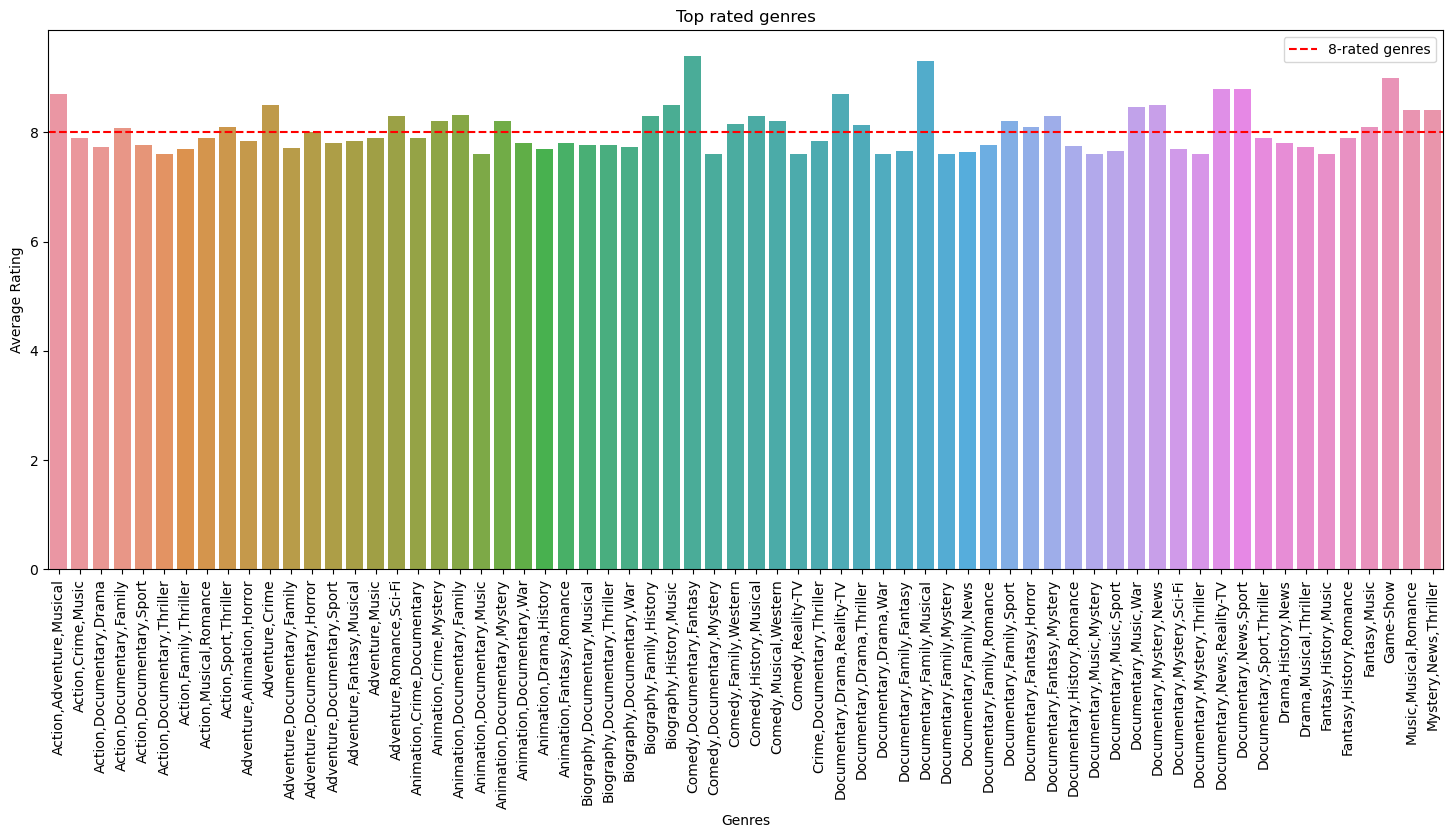

In [50]:
#bar graph of top rated genres
big = (18,7)
fig, ax = plt.subplots(figsize = big )
sns.barplot(x = 'genres', y = 'averagerating',  data = genre_rating)
plt.axhline(y=8, color='r', linestyle='--', label = '8-rated genres')
plt.xticks(rotation = 90 )
plt.legend()
plt.xlabel('Genres')
plt.ylabel('Average Rating')
plt.title('Top rated genres')
plt.show()

From the data provided, there are many ratings and for this plot we needed the highest rated movies. I therefore trimmed the data to contain
only ratings that were above a 7.6 rating.
From the available data, movies in Comedy, Documentary, Fantasy, Musical, Family, Game-show, Action, Adventure, Crime, War and Reality-TV seem to be the best performing genres.
This are just a few of the top rated genre as there are many.

#### What is the trend of movie length over the years?

In [51]:
#new dataframe with required values
run_years = imdb[['start_year', 'runtime_minutes']]
run_years = run_years.groupby('start_year')['runtime_minutes'].mean()
run_years = run_years.reset_index(name='minutes')
run_years

start_year  minutes
0        2010    95.03
1        2011    94.58
2        2012    94.28
3        2013    94.84
4        2014    95.43
5        2015    95.32
6        2016    95.98
7        2017    96.55
8        2018    98.02
9        2019   101.38

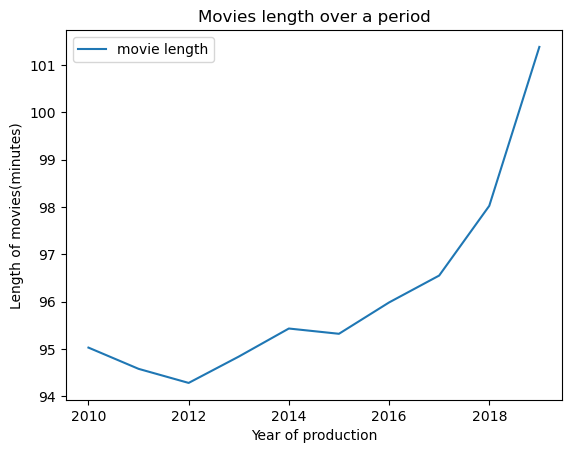

In [52]:
#plot showing movie runtime over the years
sns.lineplot(data=run_years, x='start_year', y='minutes', label = 'movie length')
plt.ylabel('Length of movies(minutes)')
plt.xlabel('Year of production')
plt.title('Movies length over a period')
plt.show()

It seems that the movie length is increasing over the years. This may due to many factors but it is evident that longer movies are being produced as the years go by

#### Which is the most common runtime?

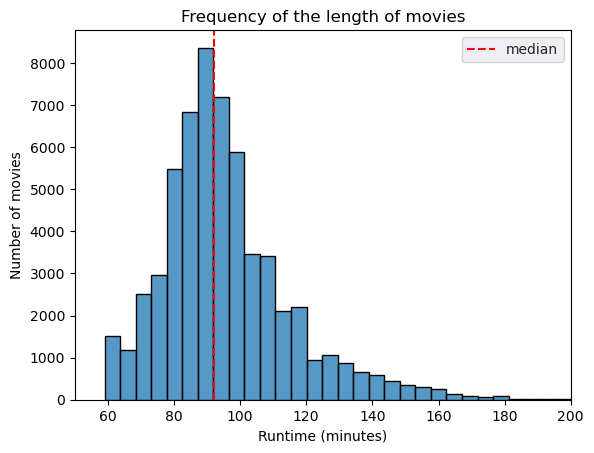

In [53]:
#histogram for most common runtime
sns.histplot(data=imdb, x='runtime_minutes', bins = 30)
sns.set_style('darkgrid')
plt.axvline(imdb['runtime_minutes'].median(), color='red', linestyle='--', label = 'median')
plt.title('Frequency of the length of movies')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Number of movies')
plt.legend()
plt.xlim(50, 200)
plt.show()

From the visualization, it appears movies with a runtime of arounf 90 minutes are very popular. This means that most movies are between 1 hour to 1 hour 30 minutes.

#### How does the runtime influence rating?

In [54]:
#dataframe for runtime and average rating
runtime_vs_rating = imdb[['runtime_minutes', 'averagerating', 'movie']]

In [55]:
runtime_vs_rating = runtime_vs_rating.groupby('runtime_minutes')['averagerating'].mean()
runtime_vs_rating = runtime_vs_rating.reset_index(name='averagerating')


In [56]:
runtime_vs_rating

runtime_minutes  averagerating
0              59.00           7.01
1              60.00           6.98
2              61.00           6.83
3              62.00           6.82
4              63.00           6.68
..               ...            ...
136           196.00           8.20
137           197.00           6.93
138           198.00           7.43
139           199.00           7.10
140           200.00           6.12

[141 rows x 2 columns]

In [57]:
#correlation between average rating and movie length
corr = runtime_vs_rating['runtime_minutes'].corr(runtime_vs_rating['averagerating'])

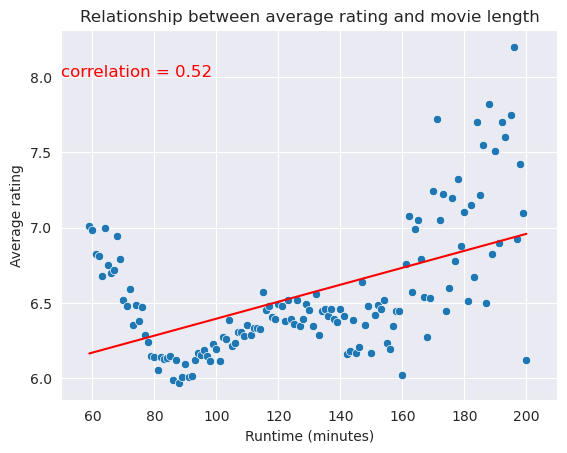

In [58]:
#plot showing runtime vs average rating
sns.scatterplot(data=runtime_vs_rating, x='runtime_minutes', y='averagerating')
plt.text(50, 8, f"correlation = {corr:.2f}", fontsize=12, color='red')
sns.set_style('darkgrid')
x = runtime_vs_rating['runtime_minutes']
y = runtime_vs_rating['averagerating']
plt.plot(np.unique(x),
         np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
plt.title('Relationship between average rating and movie length')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Average rating')
plt.xlim(50, 210)
plt.show()

It seems that as runtime increases so does the average rating. The correlation indicates a moderate positive relationship between the two. This means that as runtime increases, the average rating tends to increase and vice versa which is further visible in the scatter plot
There could be other factors affecting this.

### Visualization of bom and tn dataframe

In [59]:
bom_and_tn.head(5)

movie studio    year  production_budget  \
0                 Toy Story 3     BV 2010.00       200000000.00   
3                   Inception     WB 2010.00       160000000.00   
4         Shrek Forever After   P/DW 2010.00       165000000.00   
5  The Twilight Saga: Eclipse   Sum. 2010.00        68000000.00   
6                  Iron Man 2   Par. 2010.00       170000000.00   

   domestic_gross  worldwide_gross  foreign_gross  
0    415004880.00    1068879522.00   653874642.00  
3    292576195.00     835524642.00   542948447.00  
4    238736787.00     756244673.00   517507886.00  
5    300531751.00     706102828.00   405571077.00  
6    312433331.00     621156389.00   308723058.00

#### What is the relationship between production budget and worldwide gross?

In [114]:
#dataframe with specific data for this question
yearly_stats = bom_and_tn[['year', 'worldwide_gross', 'production_budget']].copy()
yearly_stats['year'] = yearly_stats['year'].astype(str).str[:4]

yearly_stats['year'] = pd.to_datetime(yearly_stats['year']).dt.strftime('%Y')
yearly_stats = yearly_stats[yearly_stats['worldwide_gross'] >= 1000000]
yearly_stats = yearly_stats.reset_index(drop=True)


In [115]:
yearly_stats = yearly_stats.groupby('year')[['worldwide_gross', 'production_budget']].mean()

yearly_stats

worldwide_gross  production_budget
year                                    
1915      11000000.00          110000.00
1916       8000000.00          200000.00
1920       3000000.00          100000.00
1925      15500000.00         2072500.00
1929       4358000.00          379000.00
...               ...                ...
2015     155188302.59        45489502.76
2016     153508731.00        47597967.91
2017     185497901.75        53530823.53
2018     201508558.21        51018604.65
2019     148337734.11        62662222.22

[91 rows x 2 columns]

In [62]:
corr_yr = yearly_stats['production_budget'].corr(yearly_stats['worldwide_gross'])
corr_yr

0.7395243968583006

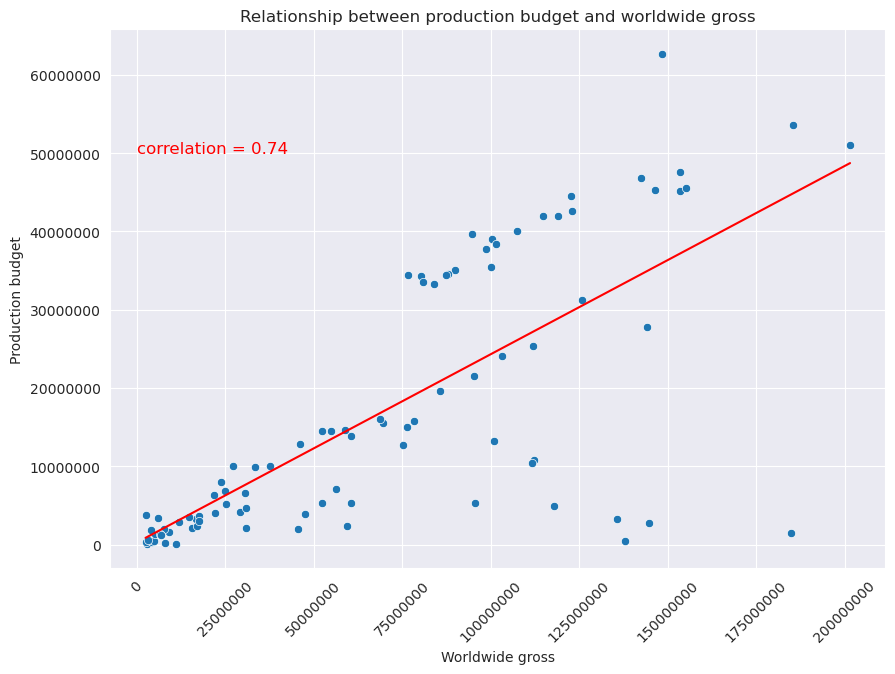

In [63]:
#plot illustrating relationship between production budget and worldwide gross
big = (10,7)
fig, ax = plt.subplots(figsize = big )

sns.scatterplot(data=yearly_stats, y='production_budget', x='worldwide_gross')
plt.text(8, (5 * 1e7), f"correlation = {corr_yr:.2f}", fontsize=12, color='red')
sns.set_style('darkgrid')
y = yearly_stats['production_budget']
x = yearly_stats['worldwide_gross']
plt.plot(np.unique(x),
         np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
plt.title('Relationship between production budget and worldwide gross')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('Worldwide gross')
plt.ylabel('Production budget')
plt.xticks(rotation = 45 )

plt.show()

From the above visualization, there is a notable trend where when the production budget is increased, the worldwide gross also increases. The correlation also supports this as it is a positive correlation 0f 0.73 which means that there is a high likelihood of worldwide gross increasing when production budget is increased. This however does not mean production budget is the only thing that influences production budget.

#### How has time influenced production budget and worldwide gross?

In [121]:
yr_budget = yearly_stats.reset_index()

# convert 'year' to int
yr_budget['year'] = yr_budget['year'].astype(int)

In [122]:
yr_budget

year  worldwide_gross  production_budget
0   1915      11000000.00          110000.00
1   1916       8000000.00          200000.00
2   1920       3000000.00          100000.00
3   1925      15500000.00         2072500.00
4   1929       4358000.00          379000.00
..   ...              ...                ...
86  2015     155188302.59        45489502.76
87  2016     153508731.00        47597967.91
88  2017     185497901.75        53530823.53
89  2018     201508558.21        51018604.65
90  2019     148337734.11        62662222.22

[91 rows x 3 columns]

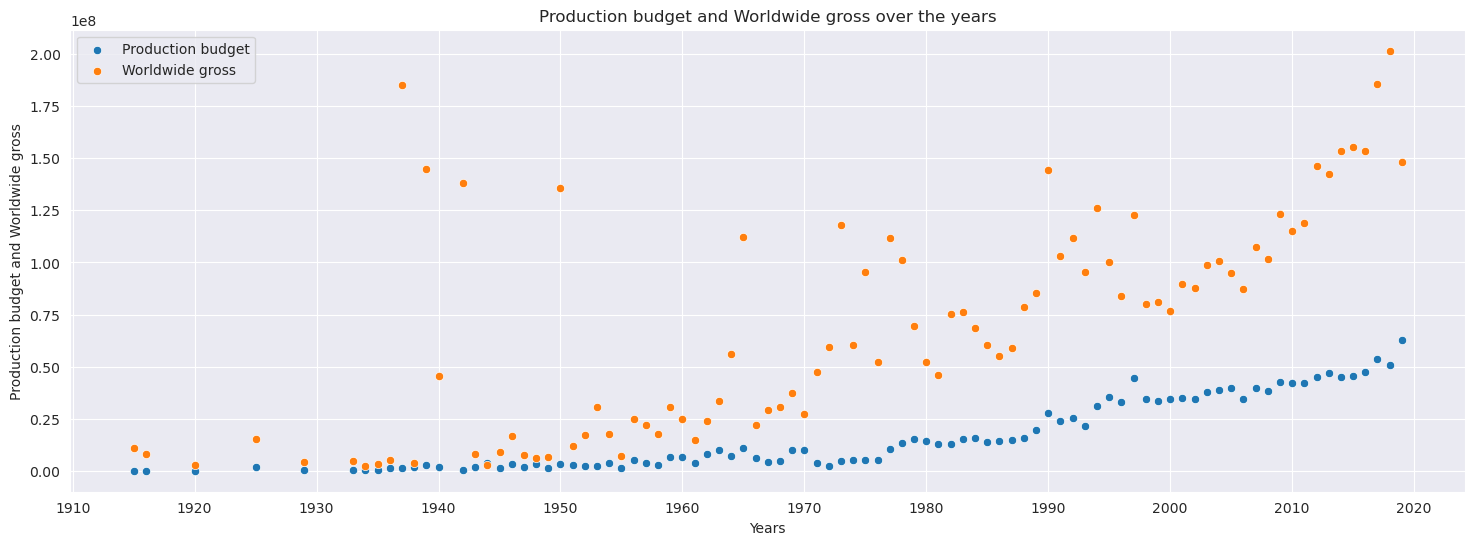

In [142]:
#plot illustrating relationship between production budget and worldwide gross over the years
fig, ax = plt.subplots(figsize = (18,6))
sns.scatterplot(data=yr_budget, x='year', y='production_budget', label = 'Production budget')
sns.scatterplot(data=yr_budget, x='year', y='worldwide_gross', label = 'Worldwide gross')

ax.set_xlabel('Years')
ax.set_ylabel('Production budget and Worldwide gross')
ax.set_title('Production budget and Worldwide gross over the years')
plt.legend()
plt.xticks(np.arange(1910, 2022, 10))


plt.show()

Here we can summarise that over the years, the movie industry has continued injecting more money into production. The worldwide gross has also risen over the years which is reflected in the data. This however does not mean there are no other factors influencing this.

#### Visualization of both dataframes combined

In [65]:
imdb_n_bom.head(5)

movie studio    year  production_budget  \
0                 Toy Story 3     BV 2010.00       200000000.00   
1                   Inception     WB 2010.00       160000000.00   
2         Shrek Forever After   P/DW 2010.00       165000000.00   
3  The Twilight Saga: Eclipse   Sum. 2010.00        68000000.00   
4                  Iron Man 2   Par. 2010.00       170000000.00   

   domestic_gross  worldwide_gross  foreign_gross  start_year  \
0    415004880.00    1068879522.00   653874642.00        2010   
1    292576195.00     835524642.00   542948447.00        2010   
2    238736787.00     756244673.00   517507886.00        2010   
3    300531751.00     706102828.00   405571077.00        2010   
4    312433331.00     621156389.00   308723058.00        2010   

   runtime_minutes                      genres  averagerating  numvotes  \
0           103.00  Adventure,Animation,Comedy           8.30    682218   
1           148.00     Action,Adventure,Sci-Fi           8.80   1841066   
2            93.00  Adventure,Animation,Comedy           6.30    167532   
3           124.00     Adventure,Drama,Fantasy           5.00    211733   
4           124.00     Action,Adventure,Sci-Fi           7.00    657690   

                                              region  
0  AR, BG, BR, CA, CN, CZ, DK, EE, ES, FR, GE, GR...  
1  AR, BE, BG, BR, CA, CL, CO, CZ, DE, DK, EE, ES...  
2  AR, BE, BG, BR, CA, CM, CZ, DE, DK, EE, ES, FI...  
3  AL, AR, BG, BR, CA, CZ, DE, DK, EE, ES, FI, FR...  
4  AR, BG, BR, CA, CZ, DK, EE, ES, FR, GB, GE, GR...

#### Does studio budget affect movie gross?

In [66]:
studio_money = imdb_n_bom[['studio', 'worldwide_gross', 'production_budget']]

In [67]:
studio_money = studio_money.groupby('studio')[['worldwide_gross', 'production_budget']].mean()
studio_money

worldwide_gross  production_budget
studio                                     
A24          17977546.15         6980000.00
ALP           2923959.00        26000000.00
ATO           2272186.00        12500000.00
Affirm       15735746.00         3500000.00
Alc            161097.00        10000000.00
...                  ...                ...
WB          144150573.01        52376772.69
WB (NL)     216790496.34        55697560.98
WHE            382946.00         7000000.00
Wein.        69159160.49        20688372.09
Yash         39398223.50        10100000.00

[88 rows x 2 columns]

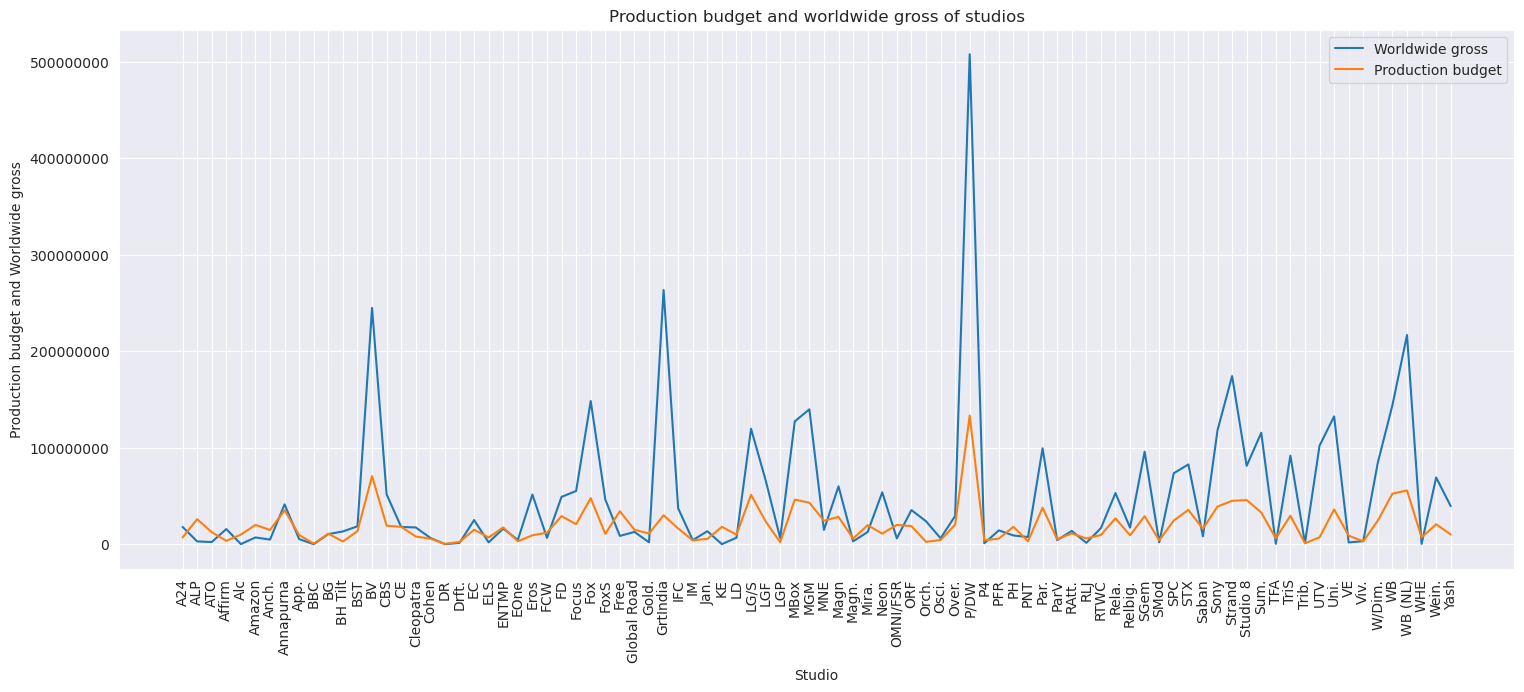

In [68]:
fig, ax = plt.subplots(figsize = (18,7))
sns.lineplot(data=studio_money, x= 'studio', y='worldwide_gross', label = 'Worldwide gross')
sns.lineplot(data=studio_money, x= 'studio', y='production_budget', label = 'Production budget')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation = 90)
ax.set_xlabel('Studio')
ax.set_ylabel('Production budget and Worldwide gross')
ax.set_title('Production budget and worldwide gross of studios')
plt.show()

The various studios have different budgets as is evident in the plot. It seems that a higher budget does play a role on the worlwide gross of the studio. This however is not the case in all the studios. This can be influenced by factors such as movie reception in the market.

#### What is the trend of movies produced per year?

In [213]:
# drop rows where titleType is not 'movie' or 'tvMovie'
movies_year = movies_year[movies_year['titleType'].isin(['movie', 'tvMovie'])]

# convert non-numeric runtimeMinutes to NaN
movies_year['runtimeMinutes'] = pd.to_numeric(movies_year['runtimeMinutes'], errors='coerce')

# filter runtimeMinutes to only include values greater than or equal to 60
movies_year = movies_year[movies_year['runtimeMinutes'].notnull() & (movies_year['runtimeMinutes'] >= 60) ]

In [214]:
#customizing the dataframe to be used
grouped = movies_year.groupby('startYear')['primaryTitle'].count().reset_index(name='movie_count')
grouped_filtered.loc[:, 'startYear'] = grouped_filtered['startYear'].astype(int)
grouped_filtered = grouped_filtered[grouped_filtered['startYear'] <= 2022]
movies_per_year = grouped_filtered 
movies_per_year


startYear  movie_count
0         1896            1
1         1897            1
2         1899            1
3         1900            1
4         1903            1
..         ...          ...
119       2018        13909
120       2019        13875
121       2020        11037
122       2021        12050
123       2022        12128

[124 rows x 2 columns]

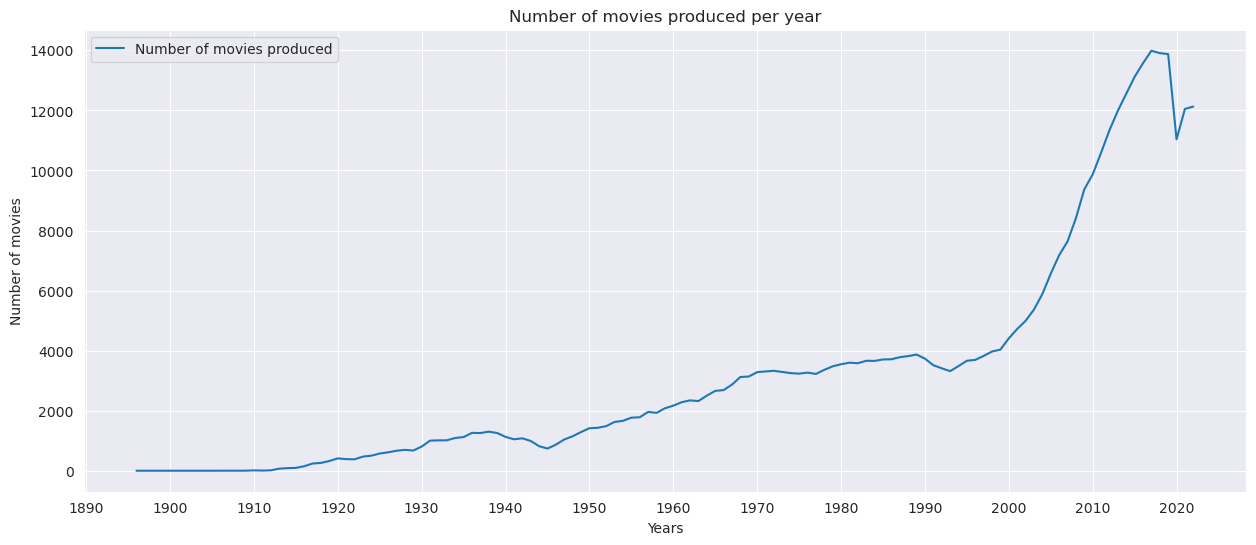

In [215]:
#plot for movies produced each year
fig, ax = plt.subplots(figsize = (15,6))
sns.lineplot(data=movies_per_year, x='startYear', y='movie_count', label = 'Number of movies produced')

plt.ticklabel_format(style='plain', axis='y')
ax.set_xlabel('Years')
ax.set_ylabel('Number of movies')
ax.set_title('Number of movies produced per year')
plt.legend()
plt.xticks(np.arange(1890, 2022, 10))

plt.show()

From this, an upward trajectory is clearly visible from 1900 to 2019. After 2019, the number of movies produced dropped which can be explained by Covid-19 as it caused shutdown of studios and there was no filming ongoing. However, after 2020, the trajectory starts going upwards after filming resumes. This shows that there are more movies being produced each year.